## <div style="text-align: right"> Mayank Pathak </div>
# Project 1 
## LBP+SVM approach on CIFAR10 Dataset 

### November 14, 2018

- 1. **Introduction** 
    - 1.1 Importing Necessary libraries
    - 1.2 Defining Hyper-Parameters
- 2. **Data Preparation**
    - 2.1  Load Data
- 3. **Defining LBP Feature Extractor**
    - 3.1 Feature Detection using LBP
    - 3.2 Training SVM
- 4. **Evaluation**

### 1. Introduction

#### 1.1 Importing necessary libraries:
Libraries used for to create this network:
    1. numpy
    2. matplotlib
    3. torch
    4. sklearn
    5. torch vision
    6. os
    7. imutils

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from skimage import feature
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data

import torchvision.transforms as transforms
import torchvision
import torch
import torchvision.datasets as dsets
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import imutils
import cv2
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

%matplotlib inline

#### 1.2 Defining Hyper-Parameters and other required Parameters
The Hyper-Parameters for this model are:

   1. **Method:** method to choose the points. 
   2. **Radius:** Radius to look for patterns.
   3. **Number of Points:** Number of points on each pattern.

In [3]:
METHOD = 'uniform'
radius = 1
n_points = 8 * radius

### 2. Data Preparation

#### 2.1 Load Data
The input images and labels are loaded using the Dataloader class. Training Data is shuffled everytime it is loaded. 50000 Training images and 10000 testing images<br>

> Number of Input Images: 60,000 <br>
> TrainImages shape: (50000,32,32,3) <br>
> TestImages shape: (10000,32,32,3)

In [4]:
trans = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])
training_set = dsets.CIFAR10(root='./data', train=True,  transform=trans, download=True)
testing_set = dsets.CIFAR10(root='./data', train=False, transform=trans, download=True)

Files already downloaded and verified
Files already downloaded and verified


### 3. Defining LBP Feature Extractor

Here different function are used to implement Local Binary Pattern Feature detection.


In [5]:
def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), normed=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')

def print_lbp_img(img, lbp_img, histogram):
    '''
    :param img: original image
    :param lbp_img: lbp image
    :param histogram: histogram of the lbp image
    :return: print the figure
    '''
    return True


def lbp_piece_vec(img, method, p, r, regions=4):
    '''
    :param img: input grayscale image
    :param method: LBP method
    :param p: number of neighbors
    :param r: radius
    :param regions: number of regions divided
    :return: lbp vector
    '''
    # crop the 32x32 image into 4 8x8 regions
    pieces = []
    vectors = []
    for i in range(regions):
        for j in range(regions):
            pieces.append(img[8*i:8*(i+1), 8*j:8*(j+1)])

    for piece in pieces:
        lbp = local_binary_pattern(piece, p, r, method)
        his, _ = np.histogram(lbp, normed=True, bins=p+2, range=(0, p+2))
        vectors.append(his)

    return np.concatenate(vectors)

def lbp_vec(img, method, p, r):
    '''
    :param img: input grayscale image
    :param method: LBP method
    :param p: number of neighbors
    :param r: radius
    :return: lbp vector
    '''
    # convert a single image into graph directly
    lbp = local_binary_pattern(img, p, r, method = "uniform")
    his, _ = np.histogram(lbp, normed=True, bins=p+2, range=(0, p+2))
    return his

def LBP_data(training_set, testing_set):
    '''
    :param training_set:
    :param testing_set:
    :return: array like training and testing data
    '''
    train_lbp_vectors = []
    train_labels = []

    for img, lab in training_set:
        img = img.numpy().squeeze()
        vector = lbp_vec(img, METHOD, n_points, radius)
        train_lbp_vectors.append(np.expand_dims(vector, axis=0))
        train_labels.append(lab)

    train_img = np.concatenate(train_lbp_vectors, axis=0)
    train_lab = np.array(train_labels)


    test_lbp_vectors = []
    test_labels = []

    for img, lab in testing_set:
        img = img.numpy().squeeze()
        vector = lbp_vec(img, METHOD, n_points, radius)
        test_lbp_vectors.append(np.expand_dims(vector, axis=0))
        test_labels.append(lab)

    test_img = np.concatenate(test_lbp_vectors, axis=0)
    test_lab = np.array(test_labels)

    return train_img, train_lab, test_img, test_lab

#### 3.1 Feature Detection using LBP
Training set and testing set is passed through the LBP feature detector as described above, and the resulting images and labels are saved<br>

In [28]:
train_img, train_lab, test_img, test_lab = LBP_data(training_set, testing_set)

/home/mp/.virtualenvs/DeepLearning/lib/python3.5/site-packages/ipykernel_launcher.py:49: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


#### 3.2 Training SVM
A Linear SVM is trained, and the performance of this trained SVM is evaluated over the test set with predited labels and true labels.

In [29]:
model = LinearSVC(C=100.0, random_state = 10)
model.fit(train_img,train_lab)

predict_labels = model.predict(test_img)

# metrics.classification_report(test_lab,predict_labels)
print("Classification report for classifier %s:\n%s\n" % (model, metrics.classification_report(test_lab,predict_labels)))

Classification report for classifier LinearSVC(C=100.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=10, tol=0.0001,
     verbose=0):
              precision    recall  f1-score   support

           0       0.31      0.50      0.39      1000
           1       0.27      0.55      0.36      1000
           2       0.14      0.01      0.03      1000
           3       0.23      0.03      0.05      1000
           4       0.26      0.29      0.27      1000
           5       0.26      0.45      0.33      1000
           6       0.30      0.68      0.42      1000
           7       0.30      0.04      0.08      1000
           8       0.29      0.06      0.09      1000
           9       0.25      0.18      0.21      1000

   micro avg       0.28      0.28      0.28     10000
   macro avg       0.26      0.28      0.22     10000
weighted avg       0.26      0.28      0.22

/home/mp/.virtualenvs/DeepLearning/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Evaluation

In [30]:
svc_score = metrics.accuracy_score(test_lab,predict_labels)
print("Support Vector Classifier : ", svc_score)


Support Vector Classifier :  0.2784


/home/mp/.virtualenvs/DeepLearning/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


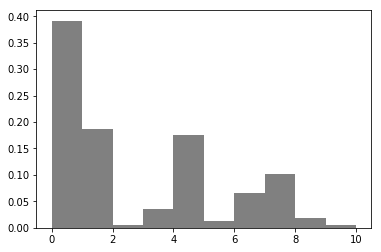

In [31]:
trans = transforms.ToPILImage()
images, labels = training_set.__getitem__(1)
# lbp = local_binary_pattern(images.numpy().squeeze(), n_points, radius, METHOD)
# displaying default to make cool image
features = feature.local_binary_pattern(images.numpy().squeeze(), n_points, radius, method="default") # method="uniform")
# cv2.imshow("input",images.astype("uint8"))
# cv2.imshow("LBP", features.astype("uint8"))
# cv2.waitKey(0)
plt.hist(features.ravel(), normed=True, bins=n_points+2, range=(0, n_points+2), color='0.5')
plt.show()

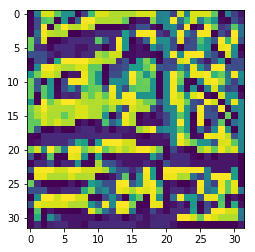

In [34]:
plt.imshow(features.astype("uint8"))#, cmap = 'gray')